In [3]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

TAR_PATH = "/home/yifan/Exp/LR/0.1/experiment1"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis2'

DEVICE='cuda:1'
########## initulize reference data and target data
from AlignVis.DataInit import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH,DEVICE)
tar_datainit = DataInit(TAR_PATH,TAR_PATH,TAR_EPOCH,DEVICE)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from AlignVis.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from AlignVis_Visualizer.visualizer import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 420.84it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 3823.81it/s]


absolute alignment indicates number: 63 label diff indicates number: 7 confidence diff indicates number: 9 high distance number: 4230


In [4]:
from AlignVis.autoencoder_generator import AutoEncoderGenerator
AutoEncoder_Generator = AutoEncoderGenerator(REF_PATH, REF_PATH, TAR_PATH, TAR_PATH, 200,200, projector, DEVICE)

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 4059.64it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 4191.39it/s]


In [26]:
import os
autoencoder = AutoEncoder_Generator.encoder_trainer(os.path.join(TAR_PATH, "pre_autoencoder.npy"),batch_size=500,num_epochs=30)

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8613.17it/s]

NET resnet18


Finish initialization...


100%|██████████| 3/3 [00:00<00:00, 7908.81it/s]


KeyboardInterrupt: 

In [27]:
from AlignVisAutoEncoder.data_loader import DataLoaderInit
batch_size = 500
data_loader = DataLoaderInit(ref_provider.train_representation(REF_EPOCH), tar_provider.train_representation(TAR_EPOCH),batch_size)
dataloader = data_loader.get_data_loader()

In [14]:
######### initialize autoencoder and dataloader #########################
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
autoencoder = SimpleAutoencoder(512,512)

In [29]:
autoencoder_path = os.path.join(TAR_PATH, "pre_autoencoder_1.npy")

In [30]:
import torch.optim as optim
import numpy as np
from pyemd import emd
import torch.nn as nn
from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph
import torch.nn.functional as F
from AlignVis.losses import KNNOverlapLoss, CKALoss, PredictionLoss, ConfidenceLoss


def earth_movers_distance(X, Y, k=5):
    X, Y = X.detach().numpy(), Y.detach().numpy()
    
    # Compute KNN graphs
    X_knn_graph = kneighbors_graph(X, k, mode='distance')
    Y_knn_graph = kneighbors_graph(Y, k, mode='distance')
    
    # Convert to dense NumPy arrays
    X_knn_matrix = X_knn_graph.toarray()
    Y_knn_matrix = Y_knn_graph.toarray()

    # Calculate the EMD between the KNN distance matrices
    distance_matrix = cdist(X_knn_matrix, Y_knn_matrix)
    first_histogram = np.ones(X_knn_matrix.shape[0]) / X_knn_matrix.shape[0]
    second_histogram = np.ones(Y_knn_matrix.shape[0]) / Y_knn_matrix.shape[0]

    return emd(first_histogram, second_histogram, distance_matrix)

def frobenius_norm_loss(predicted, target):
    return torch.norm(predicted - target, p='fro') / predicted.numel()
def label_flip_loss(X, Y, encoded_Y):
    
    pred = ref_provider.get_pred(REF_EPOCH, X.detach().numpy()).argmax(axis=1)
    new_pred_origin = tar_provider.get_pred(REF_EPOCH, Y.detach().numpy())
    new_pred = new_pred_origin.argmax(axis=1)
    flip_indices = [i for i, (x, y) in enumerate(zip(pred, new_pred)) if x != y]

    embedding_ref = projector.batch_project(REF_EPOCH, X.detach().numpy())
    embedding_trans = projector.batch_project(REF_EPOCH, encoded_Y.detach().numpy())
    inv_ref_data = projector.batch_inverse(REF_EPOCH, embedding_ref)
    inv_trans_data = projector.batch_inverse(REF_EPOCH, embedding_trans)

    low_pred = ref_provider.get_pred(REF_EPOCH, inv_ref_data).argmax(axis=1)
    low_new_pred_origin = tar_provider.get_pred(REF_EPOCH, inv_trans_data)
    low_new_pred = low_new_pred_origin.argmax(axis=1)

    low_flip_indices = [i for i, (x, y) in enumerate(zip(low_pred, low_new_pred)) if x != y]
    loss_intersection = set(flip_indices).intersection(low_flip_indices)

    loss_ppr = F.mse_loss(torch.tensor(new_pred_origin), torch.tensor(low_new_pred_origin))

    inv_trans_data_tensor = torch.tensor(inv_trans_data)
    recon_loss = F.mse_loss(inv_trans_data_tensor, Y)
        
    # Compute the edge loss
    edge_mask = (torch.tensor(pred) == torch.tensor(new_pred)).float()  # create a mask indicating which indices share the same label
    edge_mask = edge_mask.unsqueeze(-1)
    edge_loss = ((inv_trans_data_tensor - Y)**2 * edge_mask).sum() / edge_mask.sum()  # mean squared error of values at edge indices

    if len(flip_indices) == 0:
        flip_loss = 0.001
    else:
        flip_loss = len(loss_intersection) / len(flip_indices)
      
    loss = 0.1 * flip_loss + 0.2 * loss_ppr + 0.35 * recon_loss + 0.35 * edge_loss
    # loss =  abs(diff_pred - diff_low_pred)
    return loss

def prediction_loss(trans_X, Y):
    
    target_output = tar_provider.get_pred(TAR_EPOCH, Y.detach().numpy())
    # tar_output = self.get_pred(self.TAR_EPOCH, adjusted_input, self.tar_provider.content_path, self.tar_model)
    ref_output = tar_provider.get_pred(TAR_EPOCH, trans_X.detach().numpy())

    loss_ref_output = F.mse_loss(torch.tensor(ref_output), torch.tensor(target_output))
    loss_Rep = F.mse_loss(trans_X, Y)
        
    # loss = loss_tar_output + loss_Rep + self.alpha_for_pred_ref * loss_ref_output
    loss =  loss_Rep + 1 * loss_ref_output
    return loss

# Define hyperparameters
num_epochs = 10
batch_size = 50
learning_rate = 1e-4

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-5)


checkpoint = torch.load(autoencoder_path)
autoencoder.load_state_dict(checkpoint['model_state_dict'])


optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-5)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

alpha = 1 # weight for topological loss, adjust this according to your requirements


# Training loop
for epoch in range(num_epochs):
    # Initialize a list to store the predictions of unlabelled data
    unlabelled_preds = []
    for data_X, data_Y in dataloader: # Assuming you have a DataLoader instance with paired data (X, Y)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass (encoding Y and decoding to X's space)
        transformed_Y = autoencoder.encoder(data_Y)
        recon_X = autoencoder.decoder(transformed_Y)

        topological_loss_encoder = earth_movers_distance(data_Y, transformed_Y)
        topological_loss_decoder = earth_movers_distance(data_Y, recon_X)
        
        loss_f_decoder = frobenius_norm_loss(recon_X, data_X) + 10 * topological_loss_decoder
        loss_f_encoder = frobenius_norm_loss(transformed_Y, data_X) + topological_loss_encoder

        pred_loss = prediction_loss(recon_X, data_Y)
        flip_loss = label_flip_loss(data_X, data_Y, recon_X)

        #### CKA loss
        cka_loss_f = CKALoss(gamma=None, alpha=1e-8)
        cka_loss = cka_loss_f(data_Y,transformed_Y,recon_X)

        loss = loss_f_decoder + loss_f_encoder + 1 * pred_loss + cka_loss + 0.1 * flip_loss

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()


    # Print the loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss decoder: {loss_f_decoder.item():.4f},Loss encoder: {loss_f_encoder.item():.4f},pred_loss,{pred_loss.item():.4f},CKA,{cka_loss.item():.4f}，flip_loss:{flip_loss}')

torch.save({
    'epoch': TAR_EPOCH,
    'model_state_dict': autoencoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, os.path.join(TAR_PATH, "pre_autoencoder_1.npy"))


100%|██████████| 3/3 [00:00<00:00, 7458.75it/s]


Epoch [1/10], Loss: 14.8100, Loss decoder: 0.0021,Loss encoder: 0.0017,pred_loss,1.2303,CKA,0.0043，flip_loss:135.7150421142578


100%|██████████| 3/3 [00:00<00:00, 6894.75it/s]


Epoch [2/10], Loss: 27.2279, Loss decoder: 0.0029,Loss encoder: 0.0024,pred_loss,1.1400,CKA,0.0037，flip_loss:260.7891845703125


100%|██████████| 3/3 [00:00<00:00, 7260.77it/s]


Epoch [3/10], Loss: 20.6151, Loss decoder: 0.0025,Loss encoder: 0.0020,pred_loss,1.1826,CKA,0.0038，flip_loss:194.24192810058594


100%|██████████| 3/3 [00:00<00:00, 6096.37it/s]


Epoch [4/10], Loss: 20.8739, Loss decoder: 0.0025,Loss encoder: 0.0020,pred_loss,1.3122,CKA,0.0039，flip_loss:195.53317260742188


100%|██████████| 3/3 [00:00<00:00, 7593.79it/s]


Epoch [5/10], Loss: 15.6740, Loss decoder: 0.0022,Loss encoder: 0.0017,pred_loss,1.1085,CKA,0.0045，flip_loss:145.57070922851562


100%|██████████| 3/3 [00:00<00:00, 7805.78it/s]


Epoch [6/10], Loss: 17.5377, Loss decoder: 0.0023,Loss encoder: 0.0018,pred_loss,1.2157,CKA,0.0036，flip_loss:163.14244079589844


100%|██████████| 3/3 [00:00<00:00, 6619.10it/s]


Epoch [7/10], Loss: 17.6623, Loss decoder: 0.0024,Loss encoder: 0.0019,pred_loss,1.3208,CKA,0.0038，flip_loss:163.3341827392578


100%|██████████| 3/3 [00:00<00:00, 7810.62it/s]


Epoch [8/10], Loss: 17.6120, Loss decoder: 0.0023,Loss encoder: 0.0018,pred_loss,1.1552,CKA,0.0042，flip_loss:164.48468017578125


100%|██████████| 3/3 [00:00<00:00, 5480.36it/s]


Epoch [9/10], Loss: 15.8518, Loss decoder: 0.0022,Loss encoder: 0.0017,pred_loss,1.1555,CKA,0.0038，flip_loss:146.88604736328125


100%|██████████| 3/3 [00:00<00:00, 7548.24it/s]


Epoch [10/10], Loss: 16.6040, Loss decoder: 0.0022,Loss encoder: 0.0018,pred_loss,1.0688,CKA,0.0036，flip_loss:155.27532958984375


In [31]:
from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)
# eval.eval_boundary_nn_autoencoder(tar_b_features, autoencoder)

In [32]:
eval.eval_nn_train_autoencoder(15,autoencoder)

Thu May 11 01:04:33 2023 Building RP forest with 16 trees
Thu May 11 01:04:33 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Thu May 11 01:04:35 2023 Building RP forest with 16 trees
Thu May 11 01:04:35 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for autoencoder: 1.34/15 in epoch 200


1.34214

In [33]:
eval.eval_ppr_autoencoder(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 8461.58it/s]

#train# autoencoder PPR: 0.70 in epoch 200


0.69566

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8482.39it/s]


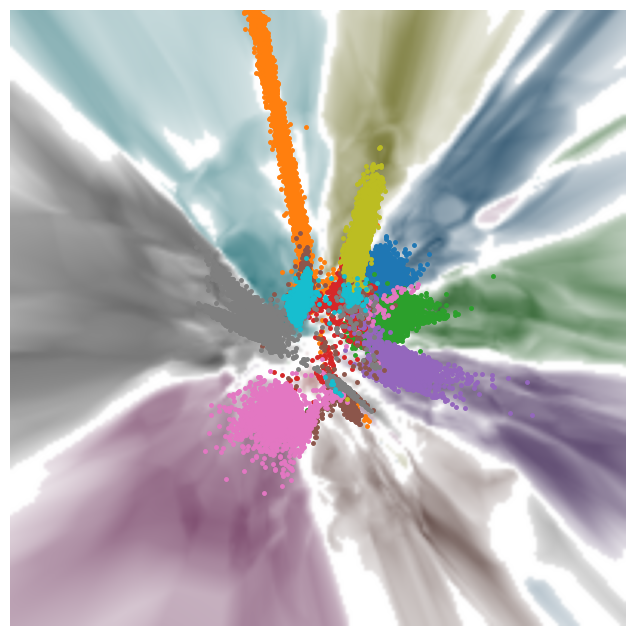

In [34]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join(TAR_PATH, "vis.png"))

In [10]:
eval.eval_move_direction_preserving(autoencoder,10,1.5)

100%|██████████| 250/250 [00:00<00:00, 8812.08it/s]


long distance move subet number is 8971, short distance move set number is 326


100%|██████████| 250/250 [00:00<00:00, 8709.46it/s]


all reference distance preserving 49919/50000
all target distance preserving 42258/50000
short distance move direction preserving 276/326
long distance move direction preserving 7541/8971


In [11]:
val_same, val_diff = eval.eval_prediction_preserving(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 8665.92it/s]

refere  predction preserving:49140/50000 0.98
target  predction preserving:34979/50000 0.70
ref&tar pred_same preserving:34665/49993 0.69
ref&tar pred_diff preserving:2/7 0.29


In [ ]:
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
encoded_Y = autoencoder.encoder(torch.Tensor(tar_train_data))
encoded_Y = encoded_Y.detach().numpy()
# indicates = np.random.choice(aligned, size=10, replace=False)
indicates = np.random.choice(np.arange(5000), size=1000, replace=False)
print('CKA between absolute alignmnet subset is:',np_cka.kernel_CKA(tar_train_data[indicates],encoded_Y[indicates]))